# Design Choices Experiments

## Experiment 1

### Experiment-1 : Percentile performance

/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/385980988.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_df['name'] = name
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/385980988.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_df['name'] = name
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/385980988.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

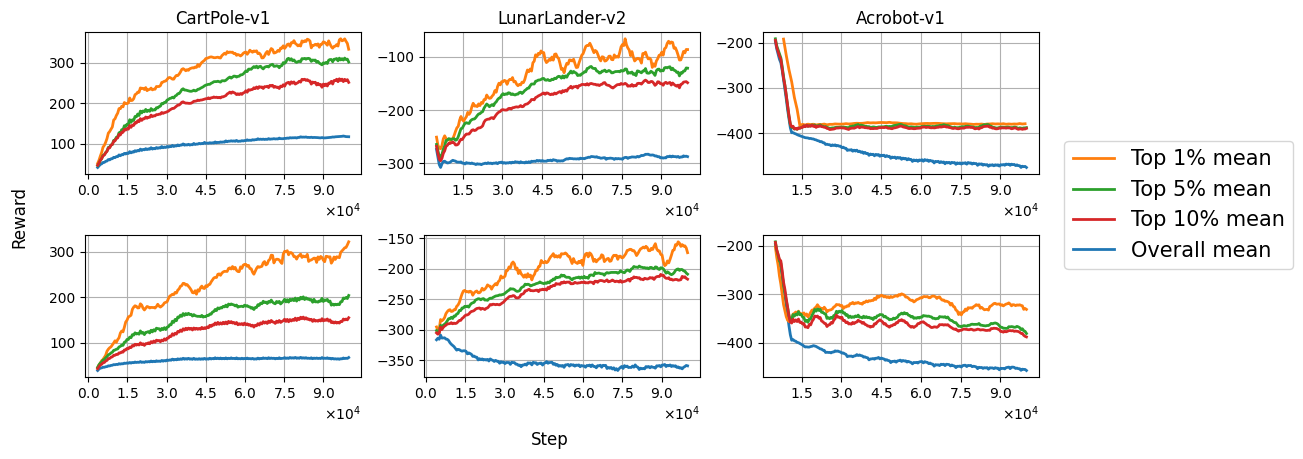

In [24]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator, ScalarFormatter

# Consolidated function to calculate mean and last reward from a CSV file
def calculate_rewards(file_path):
    if os.path.exists(file_path):
        rewards_df = pd.read_csv(file_path)
        mean_reward = rewards_df['Reward'].mean()
        last_reward = rewards_df['Reward'].iloc[-1]
        return mean_reward, last_reward
    else:
        return -2000, -2000

# Function to process a CSV file and calculate required statistics
def process_file(file_path, data_dir, prefix, mean_threshold):
    df = pd.read_csv(file_path)
    df[['mean_reward', 'last_reward']] = df['index'].apply(
        lambda index: calculate_rewards(os.path.join(data_dir, f'{prefix}_{index}.csv'))
    ).apply(pd.Series)
    
    df = df[df['mean_reward'] >= mean_threshold].sort_values(by='mean_reward', ascending=False)
    df['name'] = "Overall mean"

    quantiles = [0.99, 0.95, 0.9]
    quantile_dfs = []
    names = ["Top 1% mean", "Top 5% mean", "Top 10% mean"]
    for q, name in zip(quantiles, names):
        top_q = df['mean_reward'].quantile(q)
        quantile_df = df[df['mean_reward'] >= top_q]
        quantile_df['name'] = name
        quantile_dfs.append(quantile_df)

    return df, quantile_dfs

# Function to plot the rewards
def plot_rewards(ax, data_frames, data_dir, prefix):
    for df in data_frames:
        rewards = []
        for index, row in df.iterrows():
            if 'randsearch_saddle_lunar' in prefix:
                path = os.path.join(data_dir, f'randsearch_saddle_lunar_{row["index"]}.csv')
            else:
                path = os.path.join(data_dir, f'{prefix}_{row["index"]}.csv')
            if not os.path.exists(path):
                print(f"File not found: {path}")
                continue
            rewards_df = pd.read_csv(path)
            rewards.append(rewards_df)

        combined_df = pd.concat(rewards)
        average_reward = combined_df.groupby('Step')['Reward'].mean()
        rolling_average = average_reward.rolling(window=7).mean()

        ax.plot(rolling_average.index, rolling_average, label=f'{df["name"].values[0]}', linewidth=2)

    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure the ticks are integers
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(4, 4))
    ax.xaxis.set_tick_params(labelsize=10)
    ax.xaxis.set_major_locator(MaxNLocator(prune='both'))  # Ensure proper pruning of axis ticks

# Process and plot data
file_configs = [
    {'file': './data_2/samples_exp_1.csv', 'data_dir': 'data', 'prefix': 'rewards_random_elbe_cartpole', 'threshold': 0, 'title': 'CartPole-v1'},
    {'file': './data_2/samples_ll.csv', 'data_dir': 'data', 'prefix': 'randsearch_lunar_elbe', 'threshold': -1000, 'title': 'LunarLander-v2'},
    {'file': './data_2/samples_acrobot_elbe.csv', 'data_dir': 'data', 'prefix': 'randsearch_acrobot_elbe', 'threshold': -500, 'title': 'Acrobot-v1'},
    {'file': './data_2/samples_saddle_exp_1.csv', 'data_dir': 'data_saddle', 'prefix': 'randsearch_saddle_cartpole', 'threshold': 0, 'title': ''},
    {'file': './data_2/samples_lunar_saddle.csv', 'data_dir': 'data_saddle', 'prefix': 'randsearch_saddle_lunar', 'threshold': -1000, 'title': ''},
    {'file': './data_2/samples_acrobot_saddle.csv', 'data_dir': 'data_saddle', 'prefix': 'randsearch_saddle_acro', 'threshold': -500, 'title': ''},
]

fig = plt.figure(figsize=(12, 6))  # Adjust figsize as needed
gs = GridSpec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

ax_positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
axes = [fig.add_subplot(gs[pos]) for pos in ax_positions]

all_handles = []
all_labels = []

for config, ax in zip(file_configs, axes):
    df, quantile_dfs = process_file(config['file'], config['data_dir'], config['prefix'], config['threshold'])
    plot_rewards(ax, [df] + quantile_dfs, config['data_dir'], config['prefix'])
    ax.set_title(config['title'])
    
    handles, labels = ax.get_legend_handles_labels()
    all_handles.extend(handles)
    all_labels.extend(labels)

# Set common labels
fig.text(0.43, 0.25, 'Step', ha='center', fontsize=12)
fig.text(-0.02, 0.63, 'Reward', va='center', rotation='vertical', fontsize=12)

# Create ordered legend
unique_labels = ["Top 1% mean", "Top 5% mean", "Top 10% mean", "Overall mean"]
unique_handles = [all_handles[all_labels.index(label)] for label in unique_labels if label in all_labels]

fig.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(0.85, 0.65), fontsize=15)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to make space for the legend
plt.show()


### Experiment-1: Frequency of parameter choices in top 10% configurations

In [25]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plots_dir = "plots"
os.makedirs(plots_dir, exist_ok=True)
# Consolidated function to calculate mean and last reward from a CSV file
def calculate_rewards(file_path):
    if os.path.exists(file_path):
        rewards_df = pd.read_csv(file_path)
        mean_reward = rewards_df['Reward'].mean()
        last_reward = rewards_df['Reward'].iloc[-1]
        return mean_reward, last_reward
    else:
        return -2000, -2000

# Function to process a DataFrame and calculate required statistics
def process_dataframe(df, data_dir, prefix, mean_threshold):
    reward_data = df['index'].apply(
        lambda index: calculate_rewards(os.path.join(data_dir, f'{prefix}_{index}.csv'))
    ).apply(pd.Series)
    
    reward_data.columns = ['mean_reward', 'last_reward']
    df = pd.concat([df, reward_data], axis=1)
    df = df[df['mean_reward'] >= mean_threshold]
    return df

# Load and process data
file_configs = [
    {'file': './data_2/samples_exp_1.csv', 'data_dir': 'data', 'prefix': 'rewards_random_elbe_cartpole', 'threshold': 0, 'title': 'CartPole-v1'},
    {'file': './data_2/samples_ll.csv', 'data_dir': 'data', 'prefix': 'randsearch_lunar_elbe', 'threshold': -1000, 'title': 'LunarLander-v2'},
    {'file': './data_2/samples_acrobot_elbe.csv', 'data_dir': 'data', 'prefix': 'randsearch_acrobot_elbe', 'threshold': -500, 'title': 'Acrobot-v1'},
    {'file': './data_2/samples_saddle_exp_1.csv', 'data_dir': 'data_saddle', 'prefix': 'randsearch_saddle_cartpole', 'threshold': 0, 'title': ''},
    {'file': './data_2/samples_lunar_saddle.csv', 'data_dir': 'data_saddle', 'prefix': 'randsearch_saddle_lunar', 'threshold': -1000, 'title': ''},
    {'file': './data_2/samples_acrobot_saddle.csv', 'data_dir': 'data_saddle', 'prefix': 'randsearch_saddle_acro', 'threshold': -500, 'title': ''},

]

data_frames = []

for config in file_configs:
    df = pd.read_csv(config['file'])
    df = process_dataframe(df, config['data_dir'], config['prefix'], config['threshold'])
    df = df.sort_values(by='mean_reward', ascending=False).head(int(len(df) * 0.1))  # Select top 10%
    data_frames.append({'df': df, 'title': config['title']})

# Parameters to plot
parameters = [
    'total_iterations', 'num_minibatches', 'update_epochs', 
    'alpha', 'policy_lr', 'q_lr', 'anneal_lr', 'q_optimizer', 
    'actor_optimizer', 'average_critics', 'parametrized_sampler'
]

# Plotting the countplots for each parameter
for parameter in parameters:
    fig, axes = plt.subplots(2, 3, figsize=(6, 6))

    for i, data in enumerate(data_frames):
        df = data['df']
        if parameter not in df.columns:
            continue
        
        # Convert boolean parameter values to string for plotting
        if df[parameter].dtype == bool:
            df[parameter] = df[parameter].astype(str)
        
        order = sorted(df[parameter].dropna().unique())

        sns.countplot(ax=axes[i // 3, i % 3], x=df[parameter], order=order, palette='viridis', stat='proportion')
        axes[i // 3, i % 3].set_title(data['title'])
        axes[i // 3, i % 3].set_xlabel('')
        axes[i // 3, i % 3].set_ylabel('')
        axes[i // 3, i % 3].tick_params(axis='x', rotation=90)
    
    axes[1,1].set_xlabel(parameter, fontsize=12)
    # Adjust layout
    # fig.text(0.5, -0.04, parameter, ha='center', fontsize=12)
    # fig.text(-0.04, 0.5, 'Proportion (%)', va='center', rotation='vertical', fontsize=12)

    plt.subplots_adjust(wspace=0.4)  # Adjust wspace to increase space between columns
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plot_filename = os.path.join(plots_dir, f"experiment_1_distribution_plot_{parameter}.png")
    plt.savefig(plot_filename)
    # plt.show()

    plt.close()  # Close the plot to avoid display


/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/2326561717.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[i // 3, i % 3], x=df[parameter], order=order, palette='viridis', stat='proportion')
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/2326561717.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[i // 3, i % 3], x=df[parameter], order=order, palette='viridis', stat='proportion')
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/2326561717.py:70: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

### Experiment-1: Parameter Distributions

In [26]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def normalize_distribution(dist, min_val, max_val):
    return (np.array(dist) - min_val) / (max_val - min_val)

# Example of ranges for the three distributions
ranges = [(0, 500), (-500, 200), (-500, -100)]

# Consolidated function to calculate mean and last reward from a CSV file
def calculate_rewards(file_path):
    if os.path.exists(file_path):
        rewards_df = pd.read_csv(file_path)
        mean_reward = rewards_df['Reward'].mean()
        last_reward = rewards_df['Reward'].iloc[-1]
        return mean_reward, last_reward
    else:
        return -2000, -2000

# Function to process a DataFrame and calculate required statistics
def process_dataframe(df, data_dir, prefix, mean_threshold):
    df[['mean_reward', 'last_reward']] = df['index'].apply(
        lambda index: calculate_rewards(os.path.join(data_dir, f'{prefix}_{index}.csv'))
    ).apply(pd.Series)
    df = df[df['mean_reward'] >= mean_threshold]
    return df

# Load and process data
file_configs = [
    {'file': './data_2/samples_exp_1.csv', 'data_dir': 'data', 'prefix': 'rewards_random_elbe_cartpole', 'threshold': 0, 'title': 'CartPole-v1'},
    {'file': './data_2/samples_ll.csv', 'data_dir': 'data', 'prefix': 'randsearch_lunar_elbe', 'threshold': -1000, 'title': 'LunarLander-v2'},
    {'file': './data_2/samples_acrobot_elbe.csv', 'data_dir': 'data', 'prefix': 'randsearch_acrobot_elbe', 'threshold': -500, 'title': 'Acrobot-v1'},
    {'file': './data_2/samples_saddle_exp_1.csv', 'data_dir': 'data_saddle', 'prefix': 'randsearch_saddle_cartpole', 'threshold': 0, 'title': ''},
    {'file': './data_2/samples_lunar_saddle.csv', 'data_dir': 'data_saddle', 'prefix': 'randsearch_saddle_lunar', 'threshold': -1000, 'title': ''},
    {'file': './data_2/samples_acrobot_saddle.csv', 'data_dir': 'data_saddle', 'prefix': 'randsearch_saddle_acro', 'threshold': -500, 'title': ''},

]

data_frames = []

for config in file_configs:
    df = pd.read_csv(config['file'])
    df = process_dataframe(df, config['data_dir'], config['prefix'], config['threshold'])
    data_frames.append({'df': df, 'dir': config['data_dir'], 'prefix': config['prefix'], 'title': config['title']})

# Parameters to plot
parameters = [
    'total_iterations', 'num_minibatches', 'update_epochs', 
    'alpha', 'policy_lr', 'q_lr', 'anneal_lr', 'q_optimizer', 
    'actor_optimizer', 'average_critics', 'parametrized_sampler'
]

# Plotting
for parameter in parameters:
    fig, axes = plt.subplots(2, 3, figsize=(6, 6))
    norm_dfs = []

    for i, data in enumerate(data_frames):
        df = data['df']
        if parameter not in df.columns:
            continue
        
        # Convert boolean parameter values to string for plotting
        parameter_values = sorted(df[parameter].unique())
        if df[parameter].dtype == bool:
            df[parameter] = df[parameter].astype(str)
            parameter_values = sorted(df[parameter].unique())

        all_reward_distributions = []

        for value in parameter_values:
            subset_df = df[df[parameter] == value]

            reward_distributions = []

            for index, row in subset_df.iterrows():
                csv_path = os.path.join(data['dir'], f'{data["prefix"]}_{row["index"]}.csv')
                if os.path.exists(csv_path):
                    rewards = pd.read_csv(csv_path)
                    reward_distributions.append(rewards['Reward'].values.flatten())
                else:
                    print(f"File not found: {csv_path}")

            reward_distributions = [item for sublist in reward_distributions for item in sublist]
            all_reward_distributions.append(reward_distributions)
        
        all_reward_distributions_normalized = []

        for dist in (all_reward_distributions):
            min_val, max_val = ranges[(i%3)]  # Cycle through the specified ranges
            normalized_dist = normalize_distribution(dist, min_val, max_val)
            all_reward_distributions_normalized.append(normalized_dist)
        # Proceed with the rest of your code
        norm_dfs.append(pd.DataFrame(all_reward_distributions_normalized, index=parameter_values).T)

        box_plot = sns.boxplot(data=pd.DataFrame(all_reward_distributions, index=parameter_values).T, ax=axes[i // 3, i % 3], palette='viridis', showfliers=False, boxprops=dict(edgecolor='none'))
        

        axes[i // 3, i % 3].set_title(data['title'])
        axes[i // 3, i % 3].set_xlabel('')
        axes[i // 3, i % 3].set_ylabel('')
        axes[i // 3, i % 3].xaxis.set_tick_params(rotation=90)

    # norm_df_elbe = pd.concat(norm_dfs[:3], axis=1)
    # sns.boxplot(data=norm_df_elbe, ax=axes[0, 3], palette='viridis', showfliers=False, boxprops=dict(edgecolor='none'))
    # axes[0, 3].set_title('All')
    # norm_df_elbe = pd.concat(norm_dfs[3:-1], axis=1)
    # sns.boxplot(data=norm_df_elbe, ax=axes[1, 3], palette='viridis', showfliers=False, boxprops=dict(edgecolor='none'))
    axes[1,1].set_xlabel(parameter, fontsize=12)


    fig.text(0.5, -0.04, parameter, ha='center', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plot_filename = os.path.join(plots_dir, f"experiment_1_boxplot_{parameter}.png")
    plt.savefig(plot_filename)
    plt.close()  

### Best Runs

/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_3299/1299288653.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_df['name'] = name
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_3299/1299288653.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_df['name'] = name
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_3299/1299288653.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

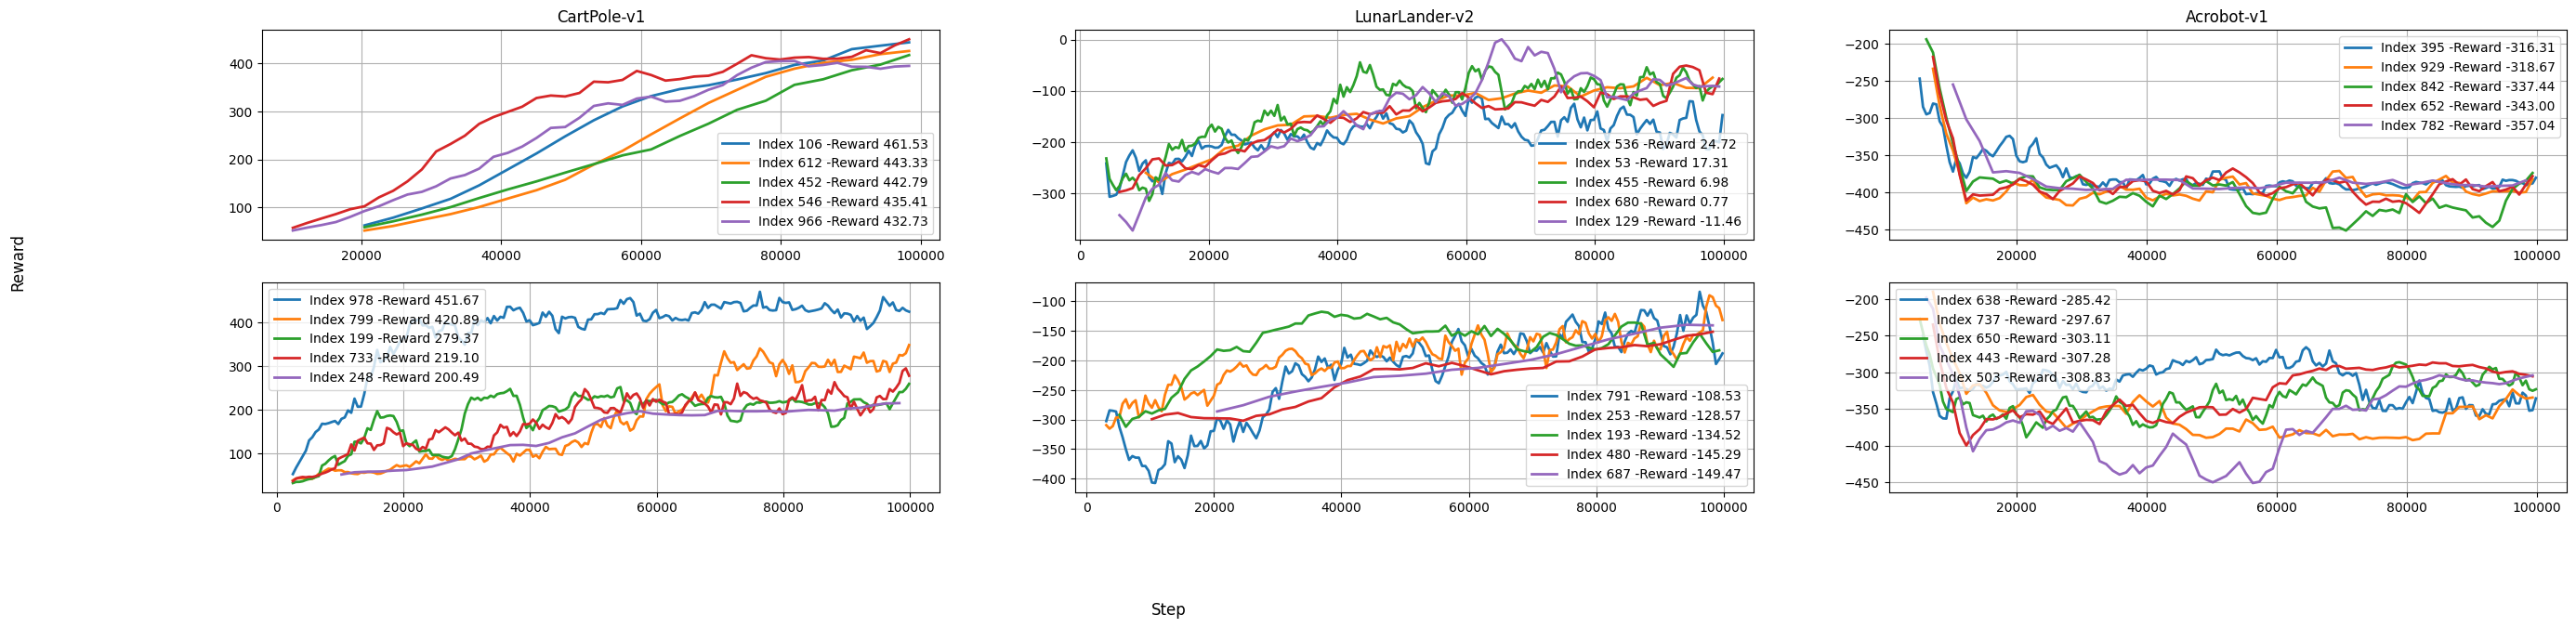

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

In [90]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Consolidated function to calculate mean and last reward from a CSV file
def calculate_rewards(file_path):
    if os.path.exists(file_path):
        rewards_df = pd.read_csv(file_path)
        mean_reward = rewards_df['Reward'].mean()
        last_reward = rewards_df['Reward'].iloc[-1]
        return mean_reward, last_reward
    else:
        return -2000, -2000

# Function to process a CSV file and calculate required statistics
def process_file(file_path, data_dir, prefix, mean_threshold):
    df = pd.read_csv(file_path)
    df[['mean_reward', 'last_reward']] = df['index'].apply(
        lambda index: calculate_rewards(os.path.join(data_dir, f'{prefix}_{index}.csv'))
    ).apply(pd.Series)
    
    df = df[df['mean_reward'] >= mean_threshold].sort_values(by='mean_reward', ascending=False)
    df['name'] = "Overall mean"

    quantiles = [0.99, 0.95, 0.9]
    quantile_dfs = []
    names = ["Top 1% mean", "Top 5% mean", "Top 10% mean"]
    for q, name in zip(quantiles, names):
        top_q = df['mean_reward'].quantile(q)
        quantile_df = df[df['mean_reward'] >= top_q]
        quantile_df['name'] = name
        quantile_dfs.append(quantile_df)

    return df, quantile_dfs

    
file_configs = [
        {'file': './data_2/samples_exp_1.csv', 'data_dir': 'data', 'prefix': 'rewards_random_elbe_cartpole', 'threshold': 0, 'title': 'CartPole-v1'},
        {'file': './data_2/samples_ll.csv', 'data_dir': 'data', 'prefix': 'randsearch_lunar_elbe', 'threshold': -1000, 'title': 'LunarLander-v2'},
        {'file': './data_2/samples_acrobot_elbe.csv', 'data_dir': 'data', 'prefix': 'randsearch_acrobot_elbe', 'threshold': -500, 'title': 'Acrobot-v1'},
        {'file': './data_2/samples_saddle_exp_1.csv', 'data_dir': 'data_saddle', 'prefix': 'randsearch_saddle_cartpole', 'threshold': 0, 'title': ''},
        {'file': './data_2/samples_lunar_saddle.csv', 'data_dir': 'data_saddle', 'prefix': 'randsearch_saddle_lunar', 'threshold': -1000, 'title': ''},
        {'file': './data_2/samples_acrobot_saddle.csv', 'data_dir': 'data_saddle', 'prefix': 'randsearch_saddle_acro', 'threshold': -500, 'title': ''},

    ]

fig = plt.figure(figsize=(32, 10))  # Adjust figsize as needed
gs = GridSpec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

ax_positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
axes = [fig.add_subplot(gs[pos]) for pos in ax_positions]

all_handles = []
all_labels = []

for config, ax in zip(file_configs, axes):
    df, _ = process_file(config['file'], config['data_dir'], config['prefix'], config['threshold'])
    # Identify the top 5 configurations based on the highest mean rewards
    top_5_runs = df.nlargest(5, 'last_reward')

    # Initialize the plot
    plt.figure(figsize=(8, 4))

    # Iterate through each of the top 5 configurations and plot their reward curves
    for _, row in top_5_runs.iterrows():
        path = os.path.join('./' + config['data_dir'], f"{config['prefix']}_{row['index']}.csv")
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
        rewards_df = pd.read_csv(path)
        
        # Calculate average reward and rolling average reward
        average_reward = rewards_df.groupby('Step')['Reward'].mean()
        rolling_average = average_reward.rolling(window=5).mean()
        
        # Plot the reward curves
        ax.plot(rolling_average.index, rolling_average, label=f'Index {row["index"]} -Reward {row["last_reward"]:.2f}', linewidth=2)
        ax.set_title(config['title'])
        ax.grid(True)
        ax.legend()
fig.text(0.43, 0.25, 'Step', ha='center', fontsize=12)
fig.text(0.04, 0.63, 'Reward', va='center', rotation='vertical', fontsize=12)

plt.show()


## Experiment 2

### Experiment-2 : Percentile performance

/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/3812020190.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_df['name'] = name
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/3812020190.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_df['name'] = name
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/3812020190.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

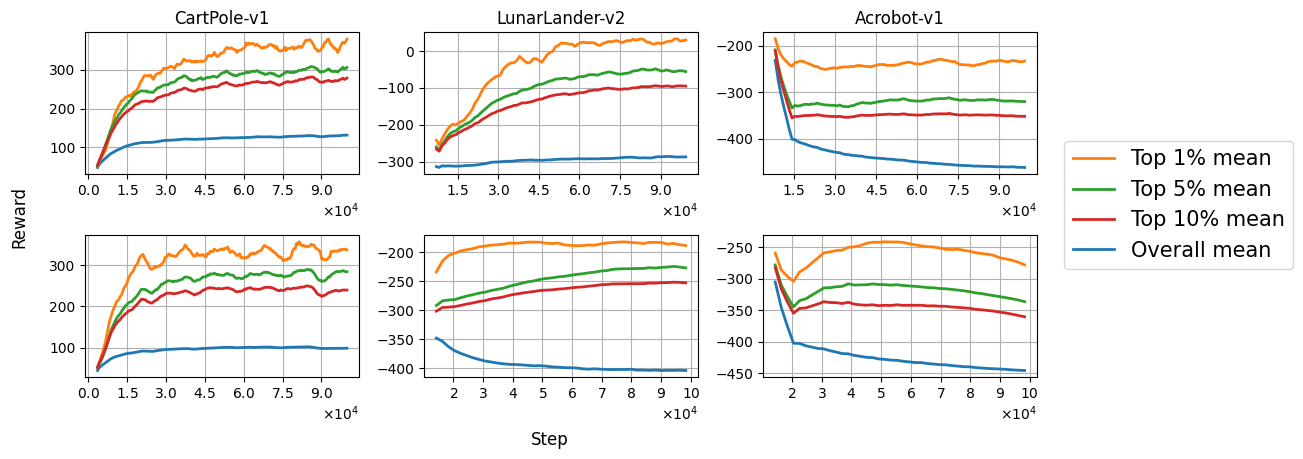

In [27]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Consolidated function to calculate mean and last reward from a CSV file
def calculate_rewards(file_path):
    if os.path.exists(file_path):
        rewards_df = pd.read_csv(file_path)
        mean_reward = rewards_df['Reward'].mean()
        last_reward = rewards_df['Reward'].iloc[-1]
        return mean_reward, last_reward
    else:
        return -2000, -2000

# Function to process a CSV file and calculate required statistics
def process_file(file_path, data_dir, prefix, mean_threshold):
    df = pd.read_csv(file_path)
    df[['mean_reward', 'last_reward']] = df['index'].apply(
        lambda index: calculate_rewards(os.path.join(data_dir, f'{prefix}_{index}.csv'))
    ).apply(pd.Series)
    
    df = df[df['mean_reward'] >= mean_threshold].sort_values(by='mean_reward', ascending=False)
    df['name'] = "Overall mean"

    quantiles = [0.99, 0.95, 0.9]
    quantile_dfs = []
    names = ["Top 1% mean", "Top 5% mean", "Top 10% mean"]
    for q, name in zip(quantiles, names):
        top_q = df['mean_reward'].quantile(q)
        quantile_df = df[df['mean_reward'] >= top_q]
        quantile_df['name'] = name
        quantile_dfs.append(quantile_df)

    return df, quantile_dfs

# Function to plot the rewards
def plot_rewards(ax, data_frames, data_dir, prefix):
    for df in data_frames:
        rewards = []
        for index, row in df.iterrows():
            if 'randsearch_saddle_lunar' in prefix:
                path = os.path.join(data_dir, f'randsearch_saddle_lunar_{row["index"]}.csv')
            else:
                path = os.path.join(data_dir, f'{prefix}_{row["index"]}.csv')
            if not os.path.exists(path):
                print(f"File not found: {path}")
                continue
            rewards_df = pd.read_csv(path)
            rewards.append(rewards_df)

        combined_df = pd.concat(rewards)
        average_reward = combined_df.groupby('Step')['Reward'].mean()
        rolling_average = average_reward.rolling(window=7).mean()

        ax.plot(rolling_average.index, rolling_average, label=f'{df["name"].values[0]}', linewidth=2)

    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure the ticks are integers
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(4, 4))
    ax.xaxis.set_tick_params(labelsize=10)
    ax.xaxis.set_major_locator(MaxNLocator(prune='both'))  # Ensure proper pruning of axis ticks

# Process and plot data
file_configs = [
    {'file': './data_2/samples_cartpole_elbe_exp_2.csv', 'data_dir': 'data_samples_cartpole_elbe_exp_2', 'prefix': 'randsearch_samples_cartpole_elbe_exp_2', 'threshold': 0, 'title': 'CartPole-v1'},
    {'file': './data_2/samples_lunar_elbe_exp_2.csv', 'data_dir': 'data_samples_lunar_elbe_exp_2', 'prefix': 'randsearch_samples_lunar_elbe_exp_2', 'threshold': -1000, 'title': 'LunarLander-v2'},
    {'file': './data_2/samples_acro_elbe_exp_2.csv', 'data_dir': 'data_samples_acro_elbe_exp_2', 'prefix': 'randsearch_samples_acro_elbe_exp_2', 'threshold': -500, 'title': 'Acrobot-v1'},
    {'file': './data_2/samples_cartpole_saddle_exp_2.csv', 'data_dir': 'data_samples_cartpole_saddle_exp_2', 'prefix': 'randsearch_samples_cartpole_saddle_exp_2', 'threshold': 0, 'title': ''},
    {'file': './data_2/samples_lunar_saddle_exp_2.csv', 'data_dir': 'data_samples_lunar_saddle_exp_2', 'prefix': 'randsearch_samples_lunar_saddle_exp_2', 'threshold': -1000, 'title': ''},
    {'file': './data_2/samples_acro_saddle_exp_2.csv', 'data_dir': 'data_samples_acro_saddle_exp_2', 'prefix': 'randsearch_samples_acro_saddle_exp_2', 'threshold': -500, 'title': ''},

]

fig = plt.figure(figsize=(12, 6))  # Adjust figsize as needed
gs = GridSpec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

ax_positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
axes = [fig.add_subplot(gs[pos]) for pos in ax_positions]

all_handles = []
all_labels = []

for config, ax in zip(file_configs, axes):
    df, quantile_dfs = process_file(config['file'], config['data_dir'], config['prefix'], config['threshold'])
    plot_rewards(ax, [df] + quantile_dfs, config['data_dir'], config['prefix'])
    ax.set_title(config['title'])
    
    handles, labels = ax.get_legend_handles_labels()
    all_handles.extend(handles)
    all_labels.extend(labels)

# Set common labels
fig.text(0.43, 0.25, 'Step', ha='center', fontsize=12)
fig.text(-0.02, 0.63, 'Reward', va='center', rotation='vertical', fontsize=12)

# Create ordered legend
unique_labels = ["Top 1% mean", "Top 5% mean", "Top 10% mean", "Overall mean"]
unique_handles = [all_handles[all_labels.index(label)] for label in unique_labels if label in all_labels]

fig.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(0.85, 0.65), fontsize=15)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to make space for the legend
plt.show()

### Experiment-2: Frequency of parameter choices in top 10% configurations

In [28]:
data_frames = []

for config in file_configs:
    df = pd.read_csv(config['file'])
    df = process_dataframe(df, config['data_dir'], config['prefix'], config['threshold'])
    df = df.sort_values(by='mean_reward', ascending=False).head(int(len(df) * 0.1))  # Select top 10%
    data_frames.append({'df': df, 'title': config['title']})

# Parameters to plot
parameters = [
    'total_iterations', 'num_minibatches', 'update_epochs', 
    'alpha', 'policy_lr', 'q_lr', 'anneal_lr', 'q_optimizer', 
    'actor_optimizer', 'average_critics', 'parametrized_sampler',
    'use_kl_loss'
]

# Plotting the countplots for each parameter
for parameter in parameters:
    fig, axes = plt.subplots(2, 3, figsize=(6, 6))

    for i, data in enumerate(data_frames):
        df = data['df']
        if parameter not in df.columns:
            continue
        
        # Convert boolean parameter values to string for plotting
        if df[parameter].dtype == bool:
            df[parameter] = df[parameter].astype(str)
        
        order = sorted(df[parameter].dropna().unique())

        sns.countplot(ax=axes[i // 3, i % 3], x=df[parameter], order=order, palette='viridis', stat='proportion')
        axes[i // 3, i % 3].set_title(data['title'])
        axes[i // 3, i % 3].set_xlabel('')
        axes[i // 3, i % 3].set_ylabel('')
        axes[i // 3, i % 3].tick_params(axis='x', rotation=90)

    # Adjust layout
    fig.text(0.5, -0.04, parameter, ha='center', fontsize=12)
    axes[1,1].set_xlabel(parameter, fontsize=12)

    plt.subplots_adjust(wspace=0.4)  # Adjust wspace to increase space between columns
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plot_filename = os.path.join(plots_dir, f"experiment_2_distribution_plot_{parameter}.png")
    plt.savefig(plot_filename)
    plt.close()

/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/4272176605.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[i // 3, i % 3], x=df[parameter], order=order, palette='viridis', stat='proportion')
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/4272176605.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[i // 3, i % 3], x=df[parameter], order=order, palette='viridis', stat='proportion')
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/4272176605.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

### Experiment-2: Parameter Distributions

In [29]:

data_frames = []

for config in file_configs:
    df = pd.read_csv(config['file'])
    df = process_dataframe(df, config['data_dir'], config['prefix'], config['threshold'])
    data_frames.append({'df': df, 'dir': config['data_dir'], 'prefix': config['prefix'], 'title': config['title']})

# Parameters to plot
parameters = [
    'total_iterations', 'num_minibatches', 'update_epochs', 
    'alpha', 'policy_lr', 'q_lr', 'anneal_lr', 'q_optimizer', 
    'actor_optimizer', 'average_critics', 'parametrized_sampler',
    'use_kl_loss'
]

# Plotting
for parameter in parameters:
    fig, axes = plt.subplots(2, 3, figsize=(6, 8))
    norm_dfs = []

    for i, data in enumerate(data_frames):
        df = data['df']
        if parameter not in df.columns:
            continue
        
        # Convert boolean parameter values to string for plotting
        parameter_values = sorted(df[parameter].unique())
        if df[parameter].dtype == bool:
            df[parameter] = df[parameter].astype(str)
            parameter_values = sorted(df[parameter].unique())

        all_reward_distributions = []

        for value in parameter_values:
            subset_df = df[df[parameter] == value]

            reward_distributions = []

            for index, row in subset_df.iterrows():
                csv_path = os.path.join(data['dir'], f'{data["prefix"]}_{row["index"]}.csv')
                if os.path.exists(csv_path):
                    rewards = pd.read_csv(csv_path)
                    reward_distributions.append(rewards['Reward'].values.flatten())
                else:
                    print(f"File not found: {csv_path}")

            reward_distributions = [item for sublist in reward_distributions for item in sublist]
            all_reward_distributions.append(reward_distributions)
        
        all_reward_distributions_normalized = []

        for dist in (all_reward_distributions):
            min_val, max_val = ranges[(i%3)]  # Cycle through the specified ranges
            normalized_dist = normalize_distribution(dist, min_val, max_val)
            all_reward_distributions_normalized.append(normalized_dist)
        # Proceed with the rest of your code
        norm_dfs.append(pd.DataFrame(all_reward_distributions_normalized, index=parameter_values).T)

        box_plot = sns.boxplot(data=pd.DataFrame(all_reward_distributions, index=parameter_values).T, ax=axes[i // 3, i % 3], palette='viridis', showfliers=False, boxprops=dict(edgecolor='none'))
        

        axes[i // 3, i % 3].set_title(data['title'])
        axes[i // 3, i % 3].set_xlabel('')
        axes[i // 3, i % 3].set_ylabel('')
        axes[i // 3, i % 3].xaxis.set_tick_params(rotation=90)

    # norm_df_elbe = pd.concat(norm_dfs[:3], axis=1)
    # sns.boxplot(data=norm_df_elbe, ax=axes[0, 3], palette='viridis', showfliers=False, boxprops=dict(edgecolor='none'))
    # axes[0, 3].set_title('All')
    # norm_df_elbe = pd.concat(norm_dfs[3:-1], axis=1)
    # sns.boxplot(data=norm_df_elbe, ax=axes[1, 3], palette='viridis', showfliers=False, boxprops=dict(edgecolor='none'))
    axes[1,1].set_xlabel(parameter, fontsize=12)


    fig.text(0.5, -0.04, parameter, ha='center', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout(rect=[0, 0, 1, 0.96])

    plot_filename = os.path.join(plots_dir, f"experiment_2_boxplot_{parameter}.png")
    plt.savefig(plot_filename)
    plt.close()

### Best Runs

/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_3299/1521830254.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_df['name'] = name
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_3299/1521830254.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_df['name'] = name
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_3299/1521830254.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

Text(0.04, 0.63, 'Reward')

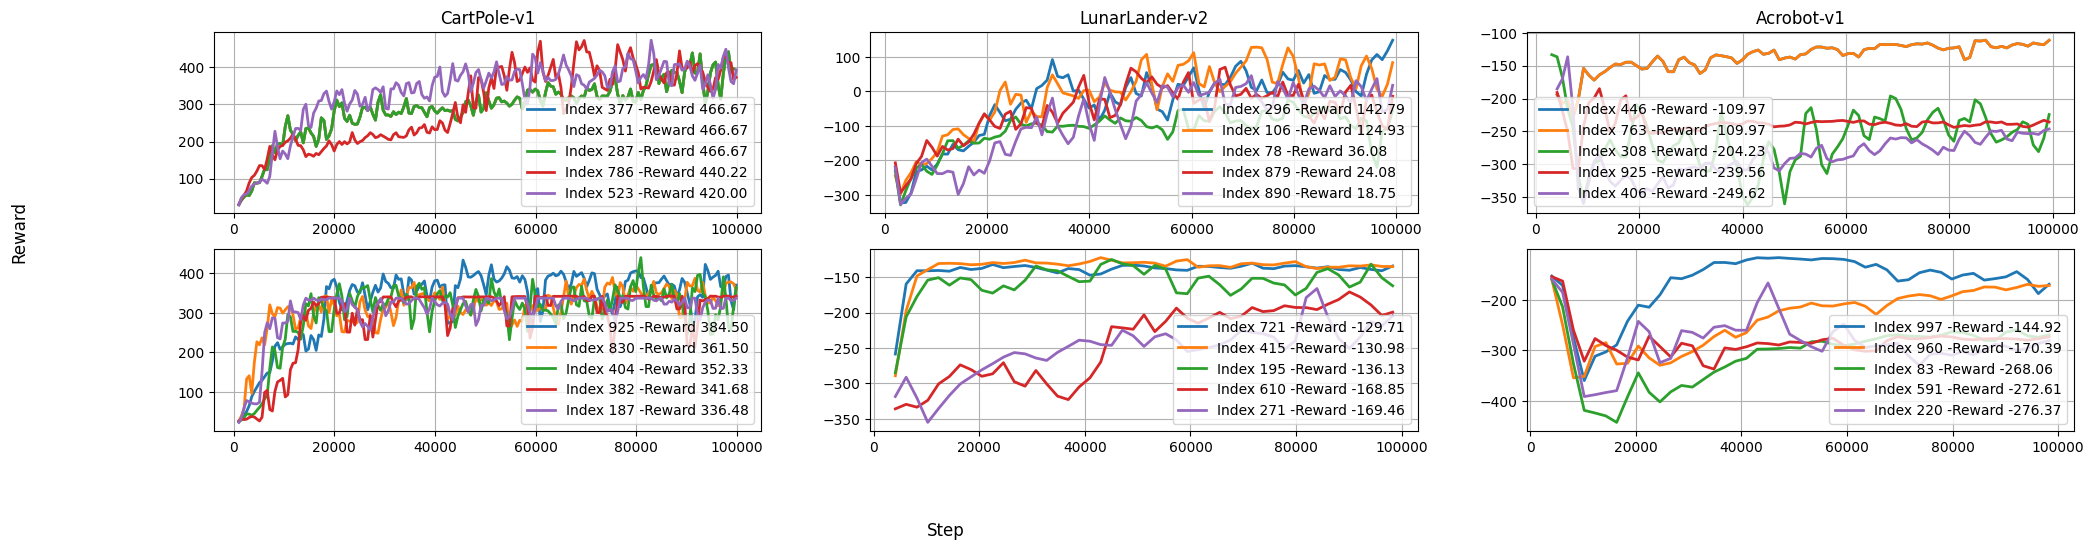

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

In [94]:
fig = plt.figure(figsize=(24, 8))  # Adjust figsize as needed
gs = GridSpec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

ax_positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
axes = [fig.add_subplot(gs[pos]) for pos in ax_positions]

all_handles = []
all_labels = []

for config, ax in zip(file_configs, axes):
    df, _ = process_file(config['file'], config['data_dir'], config['prefix'], config['threshold'])
    # Identify the top 5 configurations based on the highest mean rewards
    top_5_runs = df.nlargest(5, 'last_reward')

    # Initialize the plot
    plt.figure(figsize=(8, 4))

    # Iterate through each of the top 5 configurations and plot their reward curves
    for _, row in top_5_runs.iterrows():
        path = os.path.join('./' + config['data_dir'], f"{config['prefix']}_{row['index']}.csv")
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
        rewards_df = pd.read_csv(path)
        
        # Calculate average reward and rolling average reward
        average_reward = rewards_df.groupby('Step')['Reward'].mean()
        rolling_average = average_reward.rolling(window=2).mean()
        
        # Plot the reward curves
        ax.plot(rolling_average.index, rolling_average, label=f'Index {row["index"]} -Reward {row["last_reward"]:.2f}', linewidth=2)
        ax.set_title(config['title'])
        ax.grid(True)
        ax.legend()
fig.text(0.43, 0.25, 'Step', ha='center', fontsize=12)
fig.text(0.04, 0.63, 'Reward', va='center', rotation='vertical', fontsize=12)


## Experiment 3

### Experiment-3 : Percentile performance

/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/911008948.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_df['name'] = name
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/911008948.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_df['name'] = name
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/911008948.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

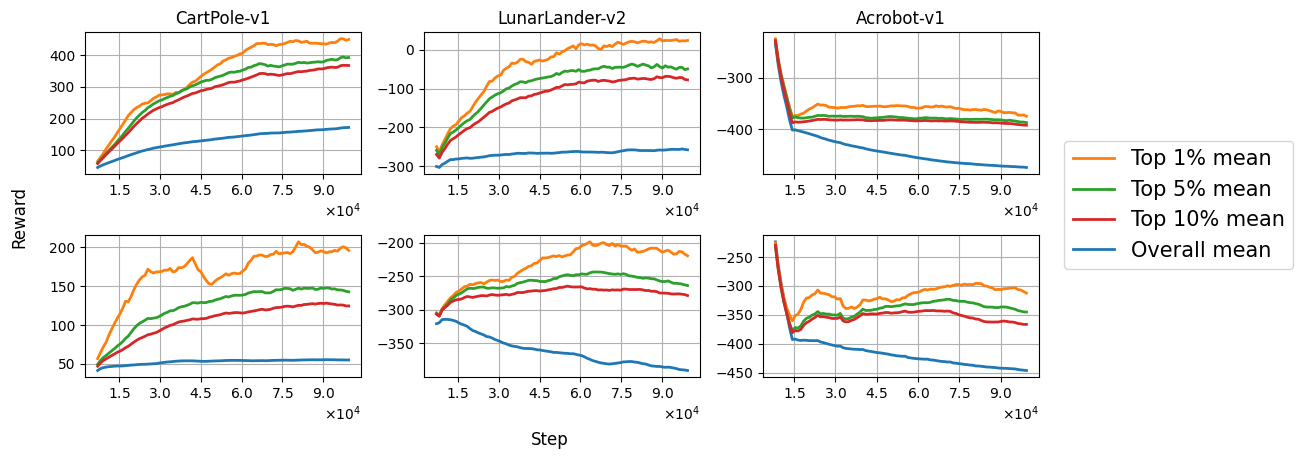

In [30]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Consolidated function to calculate mean and last reward from a CSV file
def calculate_rewards(file_path):
    if os.path.exists(file_path):
        rewards_df = pd.read_csv(file_path)
        mean_reward = rewards_df['Reward'].mean()
        last_reward = rewards_df['Reward'].iloc[-1]
        return mean_reward, last_reward
    else:
        return -2000, -2000

# Function to process a CSV file and calculate required statistics
def process_file(file_path, data_dir, prefix, mean_threshold):
    df = pd.read_csv(file_path)
    df[['mean_reward', 'last_reward']] = df['index'].apply(
        lambda index: calculate_rewards(os.path.join(data_dir, f'{prefix}_{index}.csv'))
    ).apply(pd.Series)
    
    df = df[df['mean_reward'] >= mean_threshold].sort_values(by='mean_reward', ascending=False)
    df['name'] = "Overall mean"

    quantiles = [0.99, 0.95, 0.9]
    quantile_dfs = []
    names = ["Top 1% mean", "Top 5% mean", "Top 10% mean"]
    for q, name in zip(quantiles, names):
        top_q = df['mean_reward'].quantile(q)
        quantile_df = df[df['mean_reward'] >= top_q]
        quantile_df['name'] = name
        quantile_dfs.append(quantile_df)

    return df, quantile_dfs

# Function to plot the rewards
def plot_rewards(ax, data_frames, data_dir, prefix):
    for df in data_frames:
        rewards = []
        for index, row in df.iterrows():
            if 'randsearch_saddle_lunar' in prefix:
                path = os.path.join(data_dir, f'randsearch_saddle_lunar_{row["index"]}.csv')
            else:
                path = os.path.join(data_dir, f'{prefix}_{row["index"]}.csv')
            if not os.path.exists(path):
                print(f"File not found: {path}")
                continue
            rewards_df = pd.read_csv(path)
            rewards.append(rewards_df)

        combined_df = pd.concat(rewards)
        average_reward = combined_df.groupby('Step')['Reward'].mean()
        rolling_average = average_reward.rolling(window=7).mean()

        ax.plot(rolling_average.index, rolling_average, label=f'{df["name"].values[0]}', linewidth=2)


    ax.grid(True)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure the ticks are integers
    ax.xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    ax.ticklabel_format(style='sci', axis='x', scilimits=(4, 4))
    ax.xaxis.set_tick_params(labelsize=10)
    ax.xaxis.set_major_locator(MaxNLocator(prune='both'))  # Ensure proper pruning of axis ticks


# Process and plot data
file_configs = [
    {'file': './data_2/samples_cartpole_elbe_exp_3.csv', 'data_dir': 'data_samples_cartpole_elbe_exp_3', 'prefix': 'randsearch_samples_cartpole_elbe_exp_3', 'threshold': 0, 'title': 'CartPole-v1'},
    {'file': './data_2/samples_lunar_elbe_exp_3.csv', 'data_dir': 'data_samples_lunar_elbe_exp_3', 'prefix': 'randsearch_samples_lunar_elbe_exp_3', 'threshold': -1000, 'title': 'LunarLander-v2'},
    {'file': './data_2/samples_acro_elbe_exp_3.csv', 'data_dir': 'data_samples_acro_elbe_exp_3', 'prefix': 'randsearch_samples_acro_elbe_exp_3', 'threshold': -500, 'title': 'Acrobot-v1'},
    {'file': './data_2/samples_cartpole_saddle_exp_3.csv', 'data_dir': 'data_samples_cartpole_saddle_exp_3', 'prefix': 'randsearch_samples_cartpole_saddle_exp_3', 'threshold': 0, 'title': ''},
    {'file': './data_2/samples_lunar_saddle_exp_3.csv', 'data_dir': 'data_samples_lunar_saddle_exp_3', 'prefix': 'randsearch_samples_lunar_saddle_exp_3', 'threshold': -1000, 'title': ''},
    {'file': './data_2/samples_acro_saddle_exp_3.csv', 'data_dir': 'data_samples_acro_saddle_exp_3', 'prefix': 'randsearch_samples_acro_saddle_exp_3', 'threshold': -500, 'title': ''},

]

fig = plt.figure(figsize=(12, 6))  # Adjust figsize as needed
gs = GridSpec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

ax_positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
axes = [fig.add_subplot(gs[pos]) for pos in ax_positions]

all_handles = []
all_labels = []

for config, ax in zip(file_configs, axes):
    df, quantile_dfs = process_file(config['file'], config['data_dir'], config['prefix'], config['threshold'])
    plot_rewards(ax, [df] + quantile_dfs, config['data_dir'], config['prefix'])
    ax.set_title(config['title'])
    
    handles, labels = ax.get_legend_handles_labels()
    all_handles.extend(handles)
    all_labels.extend(labels)

# Set common labels
fig.text(0.43, 0.25, 'Step', ha='center', fontsize=12)
fig.text(-0.02, 0.63, 'Reward', va='center', rotation='vertical', fontsize=12)

# Create ordered legend
unique_labels = ["Top 1% mean", "Top 5% mean", "Top 10% mean", "Overall mean"]
unique_handles = [all_handles[all_labels.index(label)] for label in unique_labels if label in all_labels]

fig.legend(unique_handles, unique_labels, loc='center left', bbox_to_anchor=(0.85, 0.65), fontsize=15)

plt.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust rect to make space for the legend
plt.show()

### Experiment-3: Frequency of parameter choices in top 10% configurations

In [34]:
data_frames = []

for config in file_configs:
    df = pd.read_csv(config['file'])
    df = process_dataframe(df, config['data_dir'], config['prefix'], config['threshold'])
    df = df.sort_values(by='mean_reward', ascending=False).head(int(len(df) * 0.1))  # Select top 10%
    data_frames.append({'df': df, 'title': config['title']})

# Parameters to plot
parameters = [
    'total_iterations', 'num_minibatches', 'update_epochs', 
    'alpha', 'policy_lr', 'q_lr', 'anneal_lr', 'q_optimizer', 
    'actor_optimizer', 'average_critics', 'parametrized_sampler',
    'eta'
]

# Plotting the countplots for each parameter
for parameter in parameters:
    fig, axes = plt.subplots(2, 3, figsize=(6, 6))

    for i, data in enumerate(data_frames):
        df = data['df']
        if parameter not in df.columns:
            continue
        
        # Convert boolean parameter values to string for plotting
        if df[parameter].dtype == bool:
            df[parameter] = df[parameter].astype(str)
        
        order = sorted(df[parameter].dropna().unique())

        sns.countplot(ax=axes[i // 3, i % 3], x=df[parameter], order=order, palette='viridis', stat='proportion')
        axes[i // 3, i % 3].set_title(data['title'])
        axes[i // 3, i % 3].set_xlabel('')
        axes[i // 3, i % 3].set_ylabel('')
        axes[i // 3, i % 3].tick_params(axis='x', rotation=90)

    # Adjust layout
    fig.text(0.5, -0.04, parameter, ha='center', fontsize=12)
    axes[1,1].set_xlabel(parameter, fontsize=12)

    plt.subplots_adjust(wspace=0.4)  # Adjust wspace to increase space between columns
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plot_filename = os.path.join(plots_dir, f"experiment_3_distribution_plot_{parameter}.png")
    plt.savefig(plot_filename)
    plt.close()


/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/3822413250.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[i // 3, i % 3], x=df[parameter], order=order, palette='viridis', stat='proportion')
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/3822413250.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[i // 3, i % 3], x=df[parameter], order=order, palette='viridis', stat='proportion')
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/3822413250.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the 

### Experiment-3: Parameter Distributions

In [35]:

data_frames = []

for config in file_configs:
    df = pd.read_csv(config['file'])
    df = process_dataframe(df, config['data_dir'], config['prefix'], config['threshold'])
    data_frames.append({'df': df, 'dir': config['data_dir'], 'prefix': config['prefix'], 'title': config['title']})

# Parameters to plot
parameters = [
    'total_iterations', 'num_minibatches', 'update_epochs', 
    'alpha', 'policy_lr', 'q_lr', 'anneal_lr', 'q_optimizer', 
    'actor_optimizer', 'average_critics', 'parametrized_sampler',
    'eta'
]

# Plotting
for parameter in parameters:
    fig, axes = plt.subplots(2, 3, figsize=(6, 6))
    norm_dfs = []

    for i, data in enumerate(data_frames):
        df = data['df']
        if parameter not in df.columns:
            continue
        
        # Convert boolean parameter values to string for plotting
        parameter_values = sorted(df[parameter].unique())
        if df[parameter].dtype == bool:
            df[parameter] = df[parameter].astype(str)
            parameter_values = sorted(df[parameter].unique())

        all_reward_distributions = []

        for value in parameter_values:
            subset_df = df[df[parameter] == value]

            reward_distributions = []

            for index, row in subset_df.iterrows():
                csv_path = os.path.join(data['dir'], f'{data["prefix"]}_{row["index"]}.csv')
                if os.path.exists(csv_path):
                    rewards = pd.read_csv(csv_path)
                    reward_distributions.append(rewards['Reward'].values.flatten())
                else:
                    print(f"File not found: {csv_path}")

            reward_distributions = [item for sublist in reward_distributions for item in sublist]
            all_reward_distributions.append(reward_distributions)
        
        all_reward_distributions_normalized = []

        for dist in (all_reward_distributions):
            min_val, max_val = ranges[(i%3)]  # Cycle through the specified ranges
            normalized_dist = normalize_distribution(dist, min_val, max_val)
            all_reward_distributions_normalized.append(normalized_dist)
        # Proceed with the rest of your code
        norm_dfs.append(pd.DataFrame(all_reward_distributions_normalized, index=parameter_values).T)

        box_plot = sns.boxplot(data=pd.DataFrame(all_reward_distributions, index=parameter_values).T, ax=axes[i // 3, i % 3], palette='viridis', showfliers=False, boxprops=dict(edgecolor='none'))
        

        axes[i // 3, i % 3].set_title(data['title'])
        axes[i // 3, i % 3].set_xlabel('')
        axes[i // 3, i % 3].set_ylabel('')
        axes[i // 3, i % 3].xaxis.set_tick_params(rotation=90)

    # norm_df_elbe = pd.concat(norm_dfs[:3], axis=1)
    # sns.boxplot(data=norm_df_elbe, ax=axes[0, 3], palette='viridis', showfliers=False, boxprops=dict(edgecolor='none'))
    # axes[0, 3].set_title('All')
    # norm_df_elbe = pd.concat(norm_dfs[3:-1], axis=1)
    # sns.boxplot(data=norm_df_elbe, ax=axes[1, 3], palette='viridis', showfliers=False, boxprops=dict(edgecolor='none'))

    axes[1,1].set_xlabel(parameter, fontsize=12)

    fig.text(0.5, -0.04, parameter, ha='center', fontsize=12)
    plt.xticks(rotation=90)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plot_filename = os.path.join(plots_dir, f"experiment_3_boxplot_{parameter}.png")
    plt.savefig(plot_filename)
    plt.close()

### Best Runs

/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/911008948.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_df['name'] = name
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/911008948.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quantile_df['name'] = name
/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_90639/911008948.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

Text(0.04, 0.63, 'Reward')

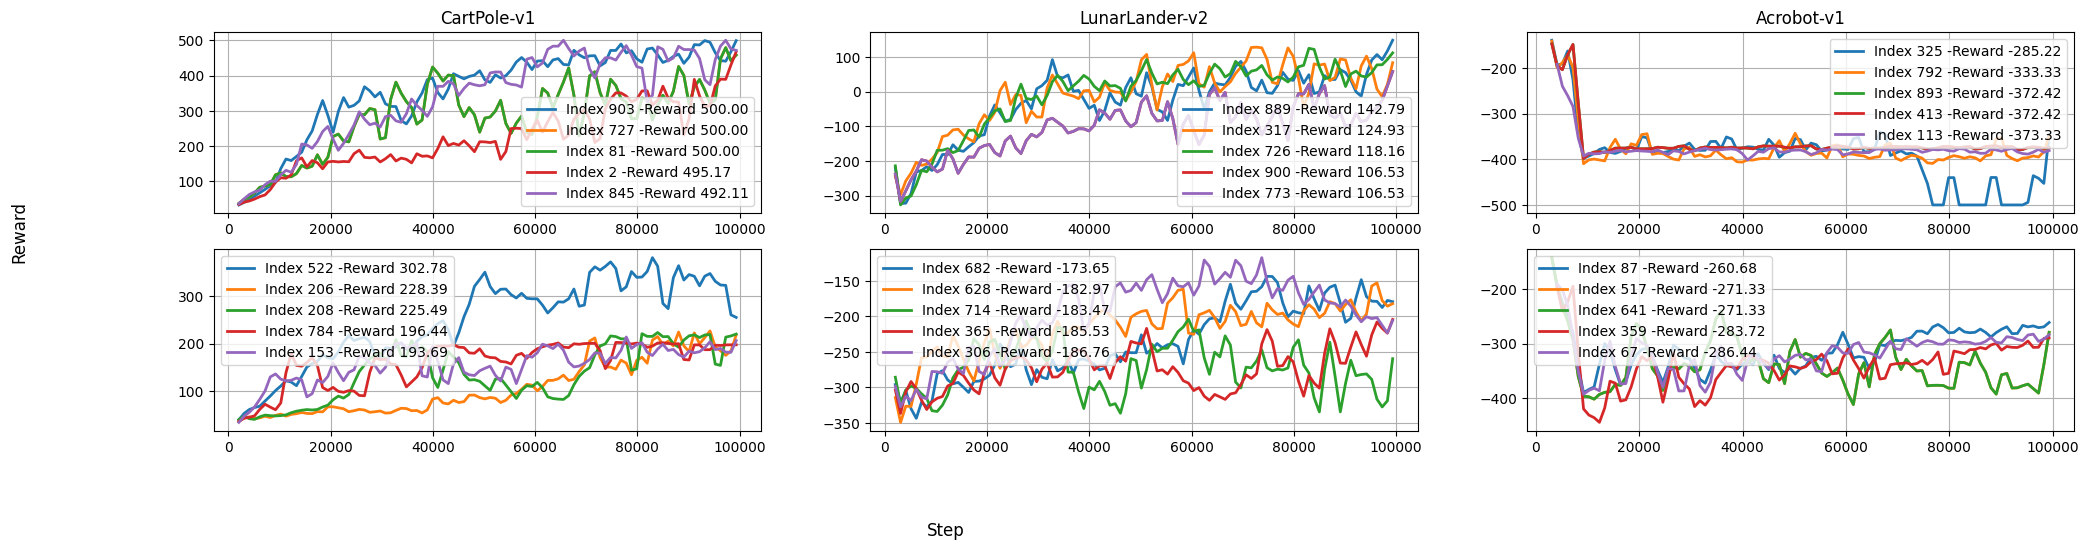

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

<Figure size 800x400 with 0 Axes>

In [36]:
fig = plt.figure(figsize=(24, 8))  # Adjust figsize as needed
gs = GridSpec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

ax_positions = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
axes = [fig.add_subplot(gs[pos]) for pos in ax_positions]

all_handles = []
all_labels = []

for config, ax in zip(file_configs, axes):
    df, _ = process_file(config['file'], config['data_dir'], config['prefix'], config['threshold'])
    # Identify the top 5 configurations based on the highest mean rewards
    top_5_runs = df.nlargest(5, 'last_reward')

    # Initialize the plot
    plt.figure(figsize=(8, 4))

    # Iterate through each of the top 5 configurations and plot their reward curves
    for _, row in top_5_runs.iterrows():
        path = os.path.join('./' + config['data_dir'], f"{config['prefix']}_{row['index']}.csv")
        if not os.path.exists(path):
            print(f"File not found: {path}")
            continue
        rewards_df = pd.read_csv(path)
        
        # Calculate average reward and rolling average reward
        average_reward = rewards_df.groupby('Step')['Reward'].mean()
        rolling_average = average_reward.rolling(window=2).mean()
        
        # Plot the reward curves
        ax.plot(rolling_average.index, rolling_average, label=f'Index {row["index"]} -Reward {row["last_reward"]:.2f}', linewidth=2)
        ax.set_title(config['title'])
        ax.grid(True)
        ax.legend()
fig.text(0.43, 0.25, 'Step', ha='center', fontsize=12)
fig.text(0.04, 0.63, 'Reward', va='center', rotation='vertical', fontsize=12)


# Episodic return Comparison

/var/folders/rz/cwn_bhpd7x9bm5nv218wrcx80000gn/T/ipykernel_3299/690056035.py:90: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(left=0.06, right=0.85, top=0.9, bottom=0.1)


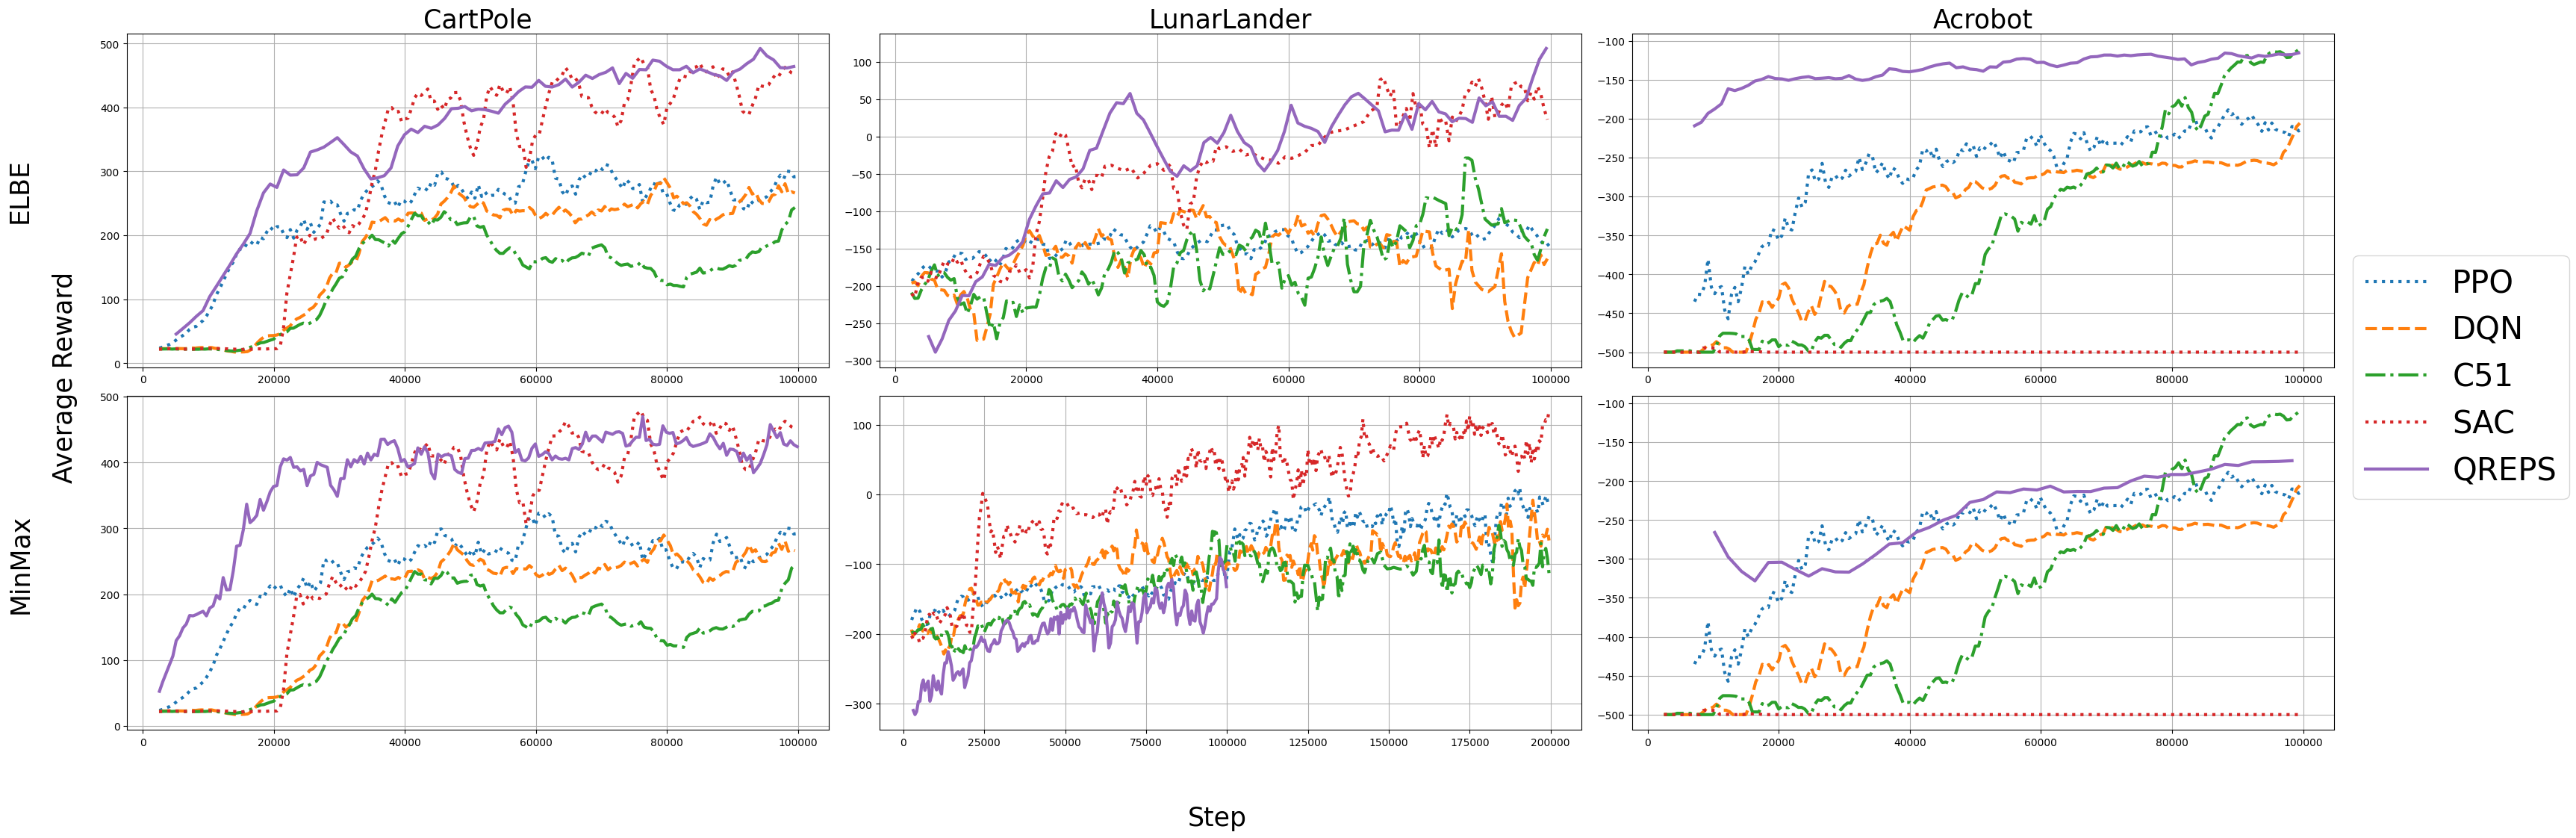

In [111]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# Define the base directories
base_dir = os.getcwd()
external_dir_elbe = '/Users/nicolasvila/workplace/uni/tfg_v2/tests/other/data'
external_dir_saddle = '/Users/nicolasvila/workplace/uni/tfg_v2/tests/other/data_saddle'

# Define file paths
file_paths = {
    "CartPole_ELBE": [
        (base_dir + '/runs_benchmark/average_reward_ppo.csv', 'PPO', ':'),
        (base_dir + '/runs_benchmark/average_reward_dqn.csv', 'DQN', '--'),
        (base_dir + '/runs_benchmark/average_reward_c51.csv', 'C51', '-.'),
        (base_dir + '/runs_benchmark/average_reward_sac.csv', 'SAC', ':'),
        ('/Users/nicolasvila/workplace/uni/tfg_v2/tests/other/data_samples_cartpole_elbe_exp_3/randsearch_samples_cartpole_elbe_exp_3_903.csv', 'QREPS', '-')
    ],
    "CartPole_Saddle": [
        (base_dir + '/runs_benchmark/average_reward_ppo.csv', 'PPO', ':'),
        (base_dir + '/runs_benchmark/average_reward_dqn.csv', 'DQN', '--'),
        (base_dir + '/runs_benchmark/average_reward_c51.csv', 'C51', '-.'),
        (base_dir + '/runs_benchmark/average_reward_sac.csv', 'SAC', ':'),
        (external_dir_saddle + '/randsearch_saddle_cartpole_978.csv', 'QREPS-Saddle', '-')
    ],
    "LunarLander_ELBE": [
        (base_dir + '/runs_benchmark/average_reward_ppo_LunarLander-v2.csv', 'PPO', ':'),
        (base_dir + '/runs_benchmark/average_reward_dqn_LunarLander-v2.csv', 'DQN', '--'),
        (base_dir + '/runs_benchmark/average_reward_c51_LunarLander-v2.csv', 'C51', '-.'),
        (base_dir + '/runs_benchmark/average_reward_sac_LunarLander-v2.csv', 'SAC', ':'),
        ('/Users/nicolasvila/workplace/uni/tfg_v2/tests/other/data_samples_lunar_elbe_exp_2/randsearch_samples_lunar_elbe_exp_2_296.csv', 'QREPS', '-')
    ],
    "LunarLander_Saddle": [
        (base_dir + '/runs_benchmark/average_reward_ppo_LunarLander-v2.csv', 'PPO', ':'),
        (base_dir + '/runs_benchmark/average_reward_dqn_LunarLander-v2.csv', 'DQN', '--'),
        (base_dir + '/runs_benchmark/average_reward_c51_LunarLander-v2.csv', 'C51', '-.'),
        (base_dir + '/runs_benchmark/average_reward_sac_LunarLander-v2.csv', 'SAC', ':'),
        ('/Users/nicolasvila/workplace/uni/tfg_v2/tests/other/data_saddle/randsearch_saddle_lunar_253.csv', 'QREPS-Saddle', '-')
    ],
    "Acrobot_ELBE": [
        (base_dir + '/runs_benchmark/average_reward_ppo_Acrobot.csv', 'PPO', ':'),
        (base_dir + '/runs_benchmark/average_reward_dqn_Acrobot.csv', 'DQN', '--'),
        (base_dir + '/runs_benchmark/average_reward_c51_Acrobot.csv', 'C51', '-.'),
        (base_dir + '/runs_benchmark/average_reward_sac_Acrobot.csv', 'SAC', ':'),
        ('/Users/nicolasvila/workplace/uni/tfg_v2/tests/other/data_samples_acro_elbe_exp_2/randsearch_samples_acro_elbe_exp_2_763.csv', 'QREPS', '-')
    ],
    "Acrobot_Saddle": [
        (base_dir + '/runs_benchmark/average_reward_ppo_Acrobot.csv', 'PPO', ':'),
        (base_dir + '/runs_benchmark/average_reward_dqn_Acrobot.csv', 'DQN', '--'),
        (base_dir + '/runs_benchmark/average_reward_c51_Acrobot.csv', 'C51', '-.'),
        (base_dir + '/runs_benchmark/average_reward_sac_Acrobot.csv', 'SAC', ':'),
        ('/Users/nicolasvila/workplace/uni/tfg_v2/tests/other/data_samples_acro_saddle_exp_2/randsearch_samples_acro_saddle_exp_2_960.csv', 'QREPS-Saddle', '-')
    ]
}

# Create a figure with subplots
fig, axs = plt.subplots(2, 3, figsize=(30, 10), constrained_layout=True)

# Titles for the subplots
titles = ['CartPole', 'LunarLander', 'Acrobot']
window_size = 5

# Plot data
for i, env in enumerate(['CartPole', 'LunarLander', 'Acrobot']):
    for j, method in enumerate(['ELBE', 'Saddle']):
        key = f"{env}_{method}"
        if key in file_paths:
            ax = axs[j, i]
            for path, label, linestyle in file_paths[key]:
                if os.path.exists(path):
                    data = pd.read_csv(path)
                    smoothed_reward = data['Reward'].rolling(window=window_size).mean()
                    ax.plot(data['Step'], smoothed_reward, label=label, linestyle=linestyle, linewidth=3)
            ax.set_title(titles[i] if j == 0 else "", fontsize=25)
            ax.grid(True)

# Set common labels and titles
fig.text(0.5, -0.1, 'Step', ha='center', fontsize=25)
fig.text(-0.02, 0.5, 'Average Reward', va='center', rotation='vertical', fontsize=25)

# Group titles for ELBE and SPO
fig.text(-0.04, 0.75, 'ELBE', va='center', rotation='vertical', fontsize=25)
fig.text(-0.04, 0.25, 'MinMax', va='center', rotation='vertical', fontsize=25)

# Add a legend outside the subplots
handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(1.0, 0.5), fontsize=30)

# Adjust layout to make room for the legend
plt.subplots_adjust(left=0.06, right=0.85, top=0.9, bottom=0.1)
plt.show()



# Dual

In [ ]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

def process_and_plot(folder_path, csv_file_path, config_column):
    def read_txt_files(folder_path):
        numbers = []
        file_indices = []
        txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
        for txt_file in txt_files:
            # Extract the row index from the file name
            match = re.match(r'.+_([0-9]+)\.txt', txt_file)
            if match:
                row_index = int(match.group(1)) - 1  # Adjust for zero-based index
                file_indices.append(row_index)
                with open(os.path.join(folder_path, txt_file), 'r') as file:
                    number = float(file.read().strip())
                    numbers.append(number)
        return numbers, file_indices

    def read_csv_file(csv_file_path):
        return pd.read_csv(csv_file_path)

    def map_numbers_to_configurations(numbers, file_indices, configurations):
        data = []
        for number, row_index in zip(numbers, file_indices):
            config_row = configurations.iloc[row_index].copy()
            config_row['number'] = number
            data.append(config_row)
        mapped_data = pd.DataFrame(data)
        return mapped_data

    def create_boxplot(data, config_column):
        plt.figure(figsize=(12, 6))
        sns.boxplot(x=config_column, y='number', data=data)
        plt.xlabel(config_column)
        plt.ylabel('Number')
        plt.title(f'Boxplot of Numbers by {config_column}')
        plt.show()

    # Step 1: Read the numbers from the TXT files
    numbers, file_indices = read_txt_files(folder_path)

    # Step 2: Read the configurations from the CSV file
    configurations = read_csv_file(csv_file_path)

    # Step 3: Map numbers to configurations
    data = map_numbers_to_configurations(numbers, file_indices, configurations)

    # Step 4: Create a boxplot
    create_boxplot(data, config_column)

# Example usage
folder_path = '/path/to/txt/files'
csv_file_path = '/path/to/configurations.csv'
config_column = 'config_column_name'  # Replace with the actual configuration column name
process_and_plot(folder_path, csv_file_path, config_column)


In [57]:
import os
import csv

# Function to extract step values from a .out file
def extract_step_values(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    step_values = []
    for line in lines:
        if line.startswith("Step"):
            parts = line.split(":")
            value = float(parts[1].strip())
            step_values.append(value)
    return step_values

# Directory containing the .out files
directory = '/Users/nicolasvila/workplace/uni/tfg_v2/tests/other/pol_eval_tabular'
csv_file = '/Users/nicolasvila/workplace/uni/tfg_v2/tests/algos/policy_eval/samples_pol_eval.csv'

# List to hold all step values from each file
rewards = []
indices = []

# Read all .out files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.out'):
        file_path = os.path.join(directory, filename)
        index = int(filename.split('arrayJob_723396_')[1].split('.')[0])+1
        step_values = extract_step_values(file_path)
        rewards.append(step_values)
        indices.append(index)   

# Transpose the list of lists to get columns
transposed_values = list(map(list, zip(*rewards)))
print(transposed_values[0])
# Write the transposed values to a CSV file
csv_file_path = 'output.csv'
with open(csv_file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerow(['File'] + [f'Step {i+1}' for i in range(len(transposed_values[0]))])
    for i, values in enumerate(transposed_values):
        csv_writer.writerow([f'File {i+1}'] + values)

print(f'Data successfully written to {csv_file_path}')


[0.0011119907804367365, 0.0012242481794858054, 5.98230068537733e-08, 4.1767066568434316e-23, 1.9617751222813544e-15, 0.0013728131373303388, 3.4704252421229405e-58, 1.542692187771826e-11, 1.6624942685296691e-06, 0.0012927028483883734, 1.597757433812101e-08, 0.00044562992766779595, 3.3159714606395946e-07, 0.0006288522988901027, 0.0014172985122857917, 0.0011084262547852123, 2.3334723717843084e-18, 0.002075597035652982, 0.00010337878243560193, 0.0011232625139874755, 9.281994706370415e-06, 6.0761583169590195e-06, 1.9868243952930968e-45, 5.995777459420997e-155, 1.4488187146410023e-10, 0.0014665281406419815, 0.004000433364047696, 5.146821526946057e-10, 6.0692720700460584e-06, 0.0006193504950677591, 3.931649124529548e-06, 0.0005442066722387618, 2.7219161185688425e-21, 0.0014687050313748687, 0.0016095023159830135, 0.020991678891543495, 9.078585676385078e-14, 1.268829280603335e-05, 0.0012395325466954853, 0.0011479401325462373, 1.3068916182329249e-18, 1.5813616789356741e-21, 9.735485154991491e-32

Configurations for the best runs based on mean reward:
Configuration for run 453: ['453', '200', '0.48648918918918926', '0.26130900900900905', '0.6378787878787878', 'SGD', '0.0', '32', 'True', 'True', 'False', 'reset']
Configuration for run 109: ['109', '150', '0.2327861861861862', '0.482485985985986', '0.7051515151515151', 'SGD', '0.0', '25', 'True', 'True', 'True', 'reset']
Configuration for run 627: ['627', '200', '0.3708966966966967', '0.20026016016016018', '0.5631313131313131', 'SGD', '0.0', '25', 'True', 'False', 'False', 'reset']
Configuration for run 446: ['446', '200', '0.21176936936936938', '0.4584667667667668', '0.6378787878787878', 'SGD', '0.0', '64', 'True', 'False', 'True', 'reset']
Configuration for run 549: ['549', '50', '0.09367487487487489', '0.2457965965965966', '0.7350505050505051', 'SGD', '0.0', '64', 'True', 'False', 'False', 'reset']


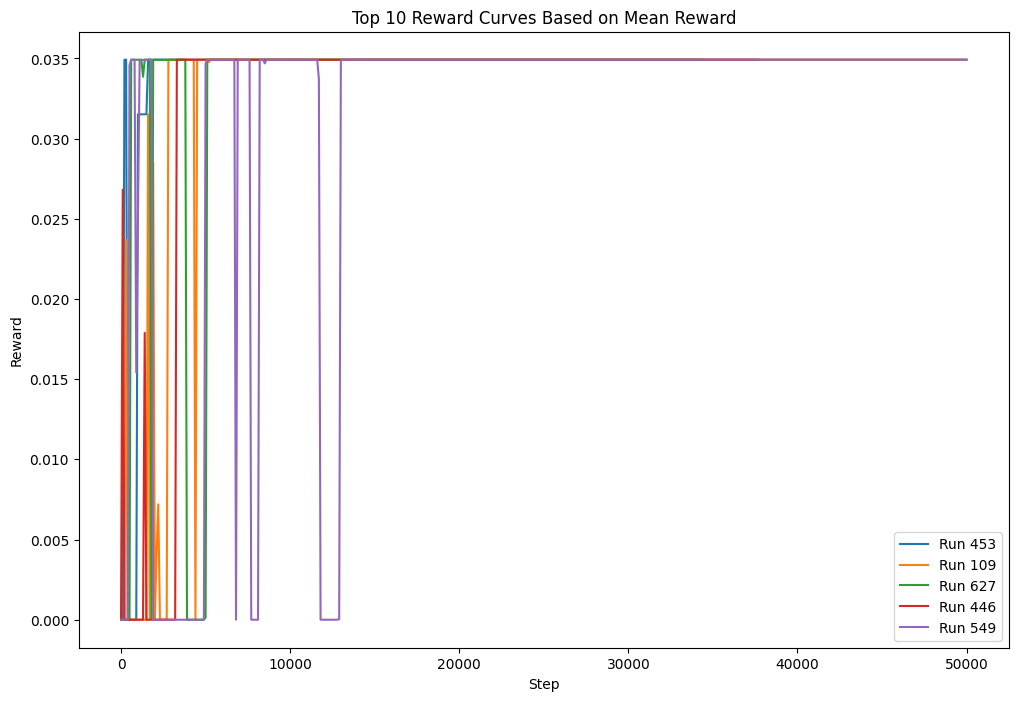

In [66]:
import os
import csv
import matplotlib.pyplot as plt
import numpy as np

# Function to extract step values from a .out file
def extract_step_values(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    step_values = []
    for line in lines:
        if line.startswith("Step"):
            parts = line.split(":")
            value = float(parts[1].strip())
            step_values.append(value)
    return step_values

# Directory containing the .out files
directory = '/Users/nicolasvila/workplace/uni/tfg_v2/tests/other/pol_eval_tabular'
csv_file = '/Users/nicolasvila/workplace/uni/tfg_v2/tests/algos/policy_eval/samples_pol_eval_unreg.csv'

# List to hold all step values from each file
rewards = []
indices = []

# Read all .out files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.out'):
        file_path = os.path.join(directory, filename)
        index = int(filename.split('arrayJob_723396_')[1].split('.')[0]) + 1
        step_values = extract_step_values(file_path)
        rewards.append(step_values)
        indices.append(index)

# Compute the mean reward of all reward curves
mean_rewards = [np.mean(reward) for reward in rewards]
best_indices = sorted(range(len(mean_rewards)), key=lambda i: mean_rewards[i], reverse=True)[:5]

# Read configurations from the CSV file
configurations = []
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    configurations = list(reader)

# Print configurations for the best runs
print("Configurations for the best runs based on mean reward:")
for i in best_indices:
    index = indices[i]
    print(f"Configuration for run {index}: {configurations[index]}")

# Plotting the top 10 reward curves based on mean reward
plt.figure(figsize=(12, 8))
for i in best_indices:
    steps = np.arange(len(rewards[i])) * 100
    plt.plot(steps, rewards[i], label=f'Run {indices[i]}')

plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Top 10 Reward Curves Based on Mean Reward')
plt.legend()
plt.show()


Configurations for the best runs based on mean reward:
Configuration for run 32: ['32', '150', '0.49399519519519525', '0.39291431431431434', '0.40616161616161617', 'SGD', '1.452202202202202', '64', 'True', 'False', 'False', 'reset']
Configuration for run 143: ['143', '150', '0.39141311311311316', '0.37039629629629633', '0.3314141414141414', 'SGD', '0.9083883883883883', '32', 'True', 'False', 'False', 'reset']


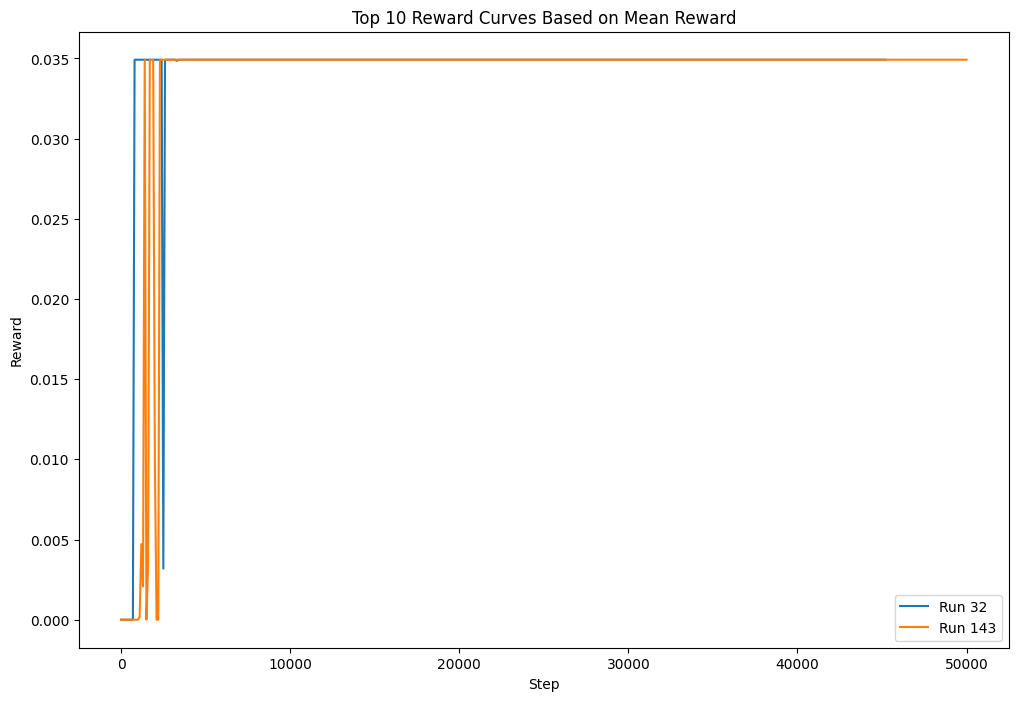

In [71]:
import os
import csv
import matplotlib.pyplot as plt
import numpy as np

# Function to extract step values from a .out file
def extract_step_values(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    step_values = []
    for line in lines:
        if line.startswith("Step"):
            parts = line.split(":")
            value = float(parts[1].strip())
            step_values.append(value)
    return step_values

# Directory containing the .out files
directory = '/Users/nicolasvila/workplace/uni/tfg_v2/tests/other/pol_eval_tabular_reg'
csv_file = '/Users/nicolasvila/workplace/uni/tfg_v2/tests/algos/policy_eval/samples_pol_eval.csv'

# List to hold all step values from each file
rewards = []
indices = []

# Read all .out files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.out'):
        file_path = os.path.join(directory, filename)
        index = int(filename.split('arrayJob_724639_')[1].split('.')[0]) + 1
        step_values = extract_step_values(file_path)
        rewards.append(step_values)
        indices.append(index)

# Compute the mean reward of all reward curves
mean_rewards = [np.mean(reward) for reward in rewards]
best_indices = sorted(range(len(mean_rewards)), key=lambda i: mean_rewards[i], reverse=True)[:2]

# Read configurations from the CSV file
configurations = []
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    configurations = list(reader)

# Print configurations for the best runs
print("Configurations for the best runs based on mean reward:")
for i in best_indices:
    index = indices[i]
    print(f"Configuration for run {index}: {configurations[index]}")

# Plotting the top 10 reward curves based on mean reward
plt.figure(figsize=(12, 8))
for i in best_indices:
    steps = np.arange(len(rewards[i])) * 100
    plt.plot(steps, rewards[i], label=f'Run {indices[i]}')

plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Top 10 Reward Curves Based on Mean Reward')
plt.legend()
plt.show()

Configurations for the best runs based on mean reward:
Configuration for run 60: ['60', '50', '0.3333666666666667', '0.033126426426426436', '0.3388888888888889', 'SGD', '1.3187387387387386', '128', 'True', 'False', 'False', 'reset']
Configuration for run 253: ['253', '50', '0.025620420420420422', '0.442453953953954', '0.5706060606060606', 'SGD', '0.4004304304304304', '128', 'True', 'True', 'False', 'reset']


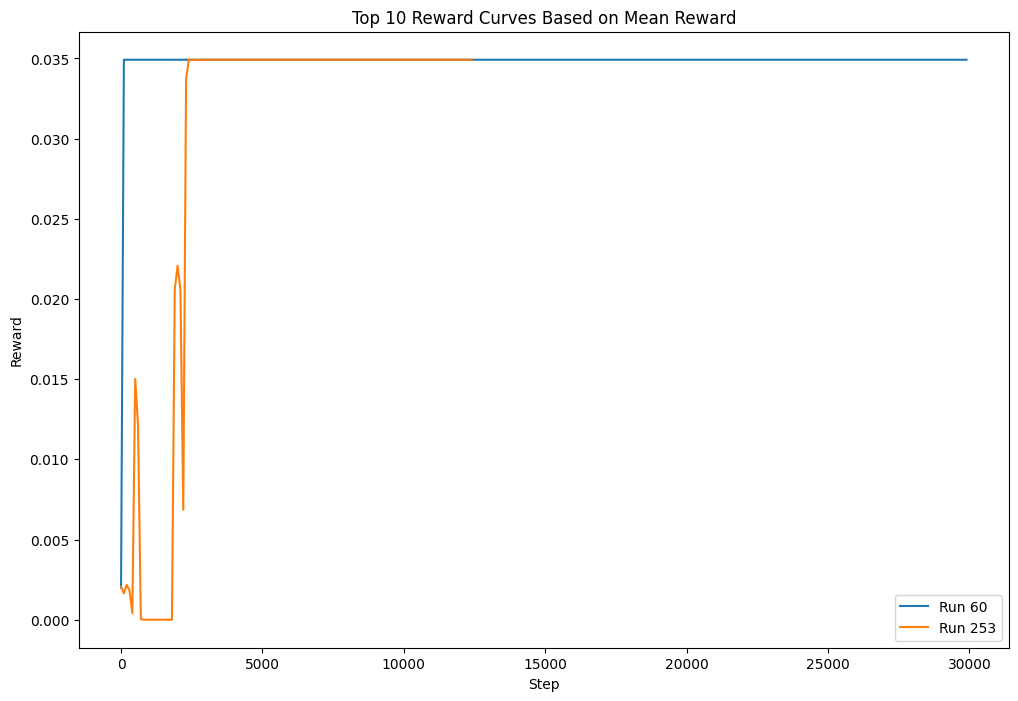

In [81]:
import os
import csv
import matplotlib.pyplot as plt
import numpy as np

# Function to extract step values from a .out file
def extract_step_values(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    step_values = []
    for line in lines:
        if line.startswith("Step"):
            parts = line.split(":")
            value = float(parts[1].strip())
            step_values.append(value)
    return step_values

# Directory containing the .out files
directory = '/Users/nicolasvila/workplace/uni/tfg_v2/tests/other/pol_eval_tabular_v2_reg'
csv_file = '/Users/nicolasvila/workplace/uni/tfg_v2/tests/algos/policy_eval/samples_pol_eval.csv'

# List to hold all step values from each file
rewards = []
indices = []

# Read all .out files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.out'):
        file_path = os.path.join(directory, filename)
        index = int(filename.split('arrayJob_726731_')[1].split('.')[0]) + 1
        step_values = extract_step_values(file_path)
        rewards.append(step_values)
        indices.append(index)

# Compute the mean reward of all reward curves
mean_rewards = [np.mean(reward) for reward in rewards]
best_indices = sorted(range(len(mean_rewards)), key=lambda i: mean_rewards[i], reverse=True)[:2]

# Read configurations from the CSV file
configurations = []
with open(csv_file, 'r') as file:
    reader = csv.reader(file)
    configurations = list(reader)

# Print configurations for the best runs
print("Configurations for the best runs based on mean reward:")
for i in best_indices:
    index = indices[i]
    print(f"Configuration for run {index}: {configurations[index]}")

# Plotting the top 10 reward curves based on mean reward
plt.figure(figsize=(12, 8))
for i in best_indices:
    steps = np.arange(len(rewards[i])) * 100
    plt.plot(steps, rewards[i], label=f'Run {indices[i]}')

plt.xlabel('Step')
plt.ylabel('Reward')
plt.title('Top 10 Reward Curves Based on Mean Reward')
plt.legend()
plt.show()